<a href="https://colab.research.google.com/github/HSV-AI/presentations/blob/master/2021/210407_HATCH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![HSV-AI Logo](https://github.com/HSV-AI/hugo-website/blob/master/static/images/logo_v9.png?raw=true)


# Classification with Scikit-Learn

This notebook is a walkthrough of different classification approaches provided by the Scikit-Learn library.

The dataset that we will use for this example was provided by the Higgs Boson Machine Learning Challenge on Kaggle and can be found here: [Dataset](https://www.kaggle.com/c/higgs-boson/data)

## From the description:

File descriptions
* training.csv - Training set of 250000 events, with an ID column, 30 feature columns, a weight column and a label column.
* test.csv - Test set of 550000 events with an ID column and 30 feature columns.
* random_submission - Sample submission file in the correct format. File format is described on the Evaluation page.
* HiggsBosonCompetition_AMSMetric - Python script to calculate the competition evaluation metric.

For detailed information on the semantics of the features, labels, and weights, see the technical documentation from the LAL website on the task.

Some details to get started:

All variables are floating point, except PRI_jet_num which is integer
variables prefixed with PRI (for PRImitives) are “raw” quantities about the bunch collision as measured by the detector.

Variables prefixed with DER (for DERived) are quantities computed from the primitive features, which were selected by  the physicists of ATLAS
it can happen that for some entries some variables are meaningless or cannot be computed; in this case, their value is −999.0, which is outside the normal range of all variables.

The full description of this dataset is available [here](https://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf)

## Loading data

First we will load this data from the csv file into a Pandas dataframe and get a look at it.

You can see that by using a 0 based index, the features are in columns 1-31 and the class is in column 33.

## Kaggle API

Using the Kaggle API is not required for this particular challenge, but is shown here in case you need to pull similar data in the future. The first step is to create an account on Kaggle and create a key for yourself.

Instead of storing the API key in Github **(NEVER DO THAT!!!)** - I'm storing it in my Google Drive and accessing it by mounting the drive into this notebook.

Using the key, I can call the Kaggle API to download the data.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install kaggle

In [4]:
!KAGGLE_CONFIG_DIR=/content/drive/MyDrive/GoogleCollab kaggle -v

Kaggle API 1.5.4


In [5]:
!KAGGLE_CONFIG_DIR=/content/drive/MyDrive/GoogleCollab kaggle competitions download -c higgs-boson

  0% 0.00/3.15k [00:00<?, ?B/s]
100% 3.15k/3.15k [00:00<00:00, 6.78MB/s]
 57% 20.0M/34.8M [00:00<00:00, 37.7MB/s]
100% 34.8M/34.8M [00:00<00:00, 99.8MB/s]
 53% 9.00M/16.9M [00:00<00:00, 32.3MB/s]
100% 16.9M/16.9M [00:00<00:00, 42.6MB/s]
  0% 0.00/2.58M [00:00<?, ?B/s]
100% 2.58M/2.58M [00:00<00:00, 173MB/s]


In [7]:
!unzip /content/training.zip

Archive:  /content/training.zip
  inflating: training.csv            


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

df = pd.read_csv("/content/training.csv") 
# Preview the first 5 lines of the loaded data 
df.head(10)

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100000,138.470,51.655,97.827,27.980,0.910,124.711,2.666,3.064,41.928,197.760,1.582,1.396,0.200,32.638,1.017,0.381,51.626,2.273,-2.414,16.824,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.240,-2.475,113.497,0.002653,s
1,100001,160.937,68.768,103.235,48.146,-999.000,-999.000,-999.000,3.473,2.078,125.157,0.879,1.414,-999.000,42.014,2.039,-3.011,36.918,0.501,0.103,44.704,-1.916,164.546,1,46.226,0.725,1.158,-999.000,-999.000,-999.000,46.226,2.233584,b
2,100002,-999.000,162.172,125.953,35.635,-999.000,-999.000,-999.000,3.148,9.336,197.814,3.776,1.414,-999.000,32.154,-0.705,-2.093,121.409,-0.953,1.052,54.283,-2.186,260.414,1,44.251,2.053,-2.028,-999.000,-999.000,-999.000,44.251,2.347389,b
3,100003,143.905,81.417,80.943,0.414,-999.000,-999.000,-999.000,3.310,0.414,75.968,2.354,-1.285,-999.000,22.647,-1.655,0.010,53.321,-0.522,-3.100,31.082,0.060,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,-0.000,5.446378,b
4,100004,175.864,16.915,134.805,16.405,-999.000,-999.000,-999.000,3.891,16.405,57.983,1.056,-1.385,-999.000,28.209,-2.197,-2.231,29.774,0.798,1.569,2.723,-0.871,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000,6.245333,b
5,100005,89.744,13.550,59.149,116.344,2.636,284.584,-0.540,1.362,61.619,278.876,0.588,0.479,0.975,53.651,0.371,1.329,31.565,-0.884,1.857,40.735,2.237,282.849,3,90.547,-2.412,-0.653,56.165,0.224,3.106,193.660,0.083414,b
6,100006,148.754,28.862,107.782,106.130,0.733,158.359,0.113,2.941,2.545,305.967,3.371,1.393,0.791,28.850,1.113,2.409,97.240,0.675,-0.966,38.421,-1.443,294.074,2,123.010,0.864,1.450,56.867,0.131,-2.767,179.877,0.002653,s
7,100007,154.916,10.418,94.714,29.169,-999.000,-999.000,-999.000,2.897,1.526,138.178,0.365,-1.305,-999.000,78.800,0.654,1.547,28.740,0.506,-1.347,22.275,-1.761,187.299,1,30.638,-0.715,-1.724,-999.000,-999.000,-999.000,30.638,0.018636,s
8,100008,105.594,50.559,100.989,4.288,-999.000,-999.000,-999.000,2.904,4.288,65.333,0.675,-1.366,-999.000,39.008,2.433,-2.532,26.325,0.210,1.884,37.791,0.024,129.804,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000,5.296003,b
9,100009,128.053,88.941,69.272,193.392,-999.000,-999.000,-999.000,1.609,28.859,255.123,0.599,0.538,-999.000,54.646,-1.533,0.416,32.742,-0.317,-0.636,132.678,0.845,294.741,1,167.735,-2.767,-2.514,-999.000,-999.000,-999.000,167.735,0.001502,s


In [40]:
print("Total number of rows: %d" % len(df))
print("Breakdown by class:")
print(df.groupby('Label').size())

Total number of rows: 10000
Breakdown by class:
Label
b    6553
s    3447
dtype: int64


In [11]:
df = df.sample(n=10000)

## Training & Validation

Before we start looking at different methods for classification, we need to split this data into a training set and a validation set. The problem is that if we train using all of the data, we do not have an independent way of testing the accuracy of the model.

Luckily, scikit-learn provides an easy way to do this: [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

First, we will slice the original dataframe to create a dataframe with only the 166 attributes, and another with only the classes.

In [41]:
from sklearn.model_selection import train_test_split

X = df.iloc[:,1:31]
y = df.iloc[:, 32]

print(X.head())

print('now the labels:')
print(y.head())
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=.25)

        DER_mass_MMC  ...  PRI_jet_all_pt
181150        70.667  ...           0.000
198020       109.703  ...          67.556
158339      -999.000  ...          47.824
12549       -999.000  ...          -0.000
194263       376.864  ...           0.000

[5 rows x 30 columns]
now the labels:
181150    b
198020    b
158339    b
12549     b
194263    b
Name: Label, dtype: object


## Classifier Testing Approach

Now that we have the data ready for training and validation, we can start working through the different classifiers provided by scikit-learn. To do that, we will look at two primary measurements of each classifier:
1. Accuracy - what percentage of the overal set did the model classify correctly
2. Confusion Matrix - which classes were classified correctly, and which were classified as the opposite

Here is a great write-up for a [Confusion Matrix](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/)

A good place to start for finding a list of classifiers is [here](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)


## Support Vector Machine

The first classifier that we will look at is the [Support Vector Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

This can be used with several different kernel types. We will start with the default 'rbf'

Accuracy: 0.692000

Confusion Matrix: 
[[1594  722]
 [  48  136]]



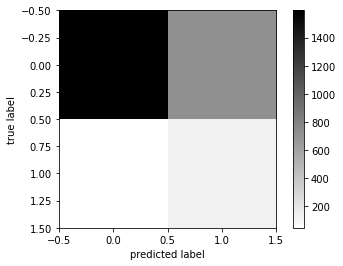

In [42]:
from sklearn.svm import SVC  # "Support Vector Classifier"
clf = SVC(kernel='rbf', gamma='scale')
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)
print("Accuracy: %f\n" % metrics.accuracy_score(ypred, ytest))

confusion_matrix = metrics.confusion_matrix(ypred, ytest)
print("Confusion Matrix: ")
print(confusion_matrix)
print()

plt.imshow(confusion_matrix,
           interpolation='nearest', cmap=plt.cm.binary)
plt.grid(False)
plt.colorbar()
plt.xlabel("predicted label")
plt.ylabel("true label");


## Support Vector Machine

Next we will try the linear classifier. Note - this takes a long time...

CPU times: user 2h 15min 33s, sys: 97.1 ms, total: 2h 15min 34s
Wall time: 2h 15min 33s
Accuracy: 0.949697

Confusion Matrix: 
[[1366   54]
 [  29  201]]



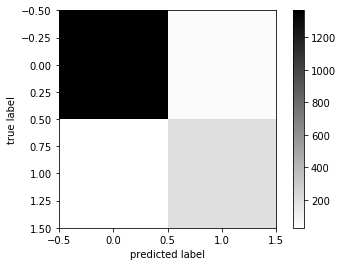

In [ ]:
# from sklearn.svm import SVC  # "Support Vector Classifier"
# clf = SVC(kernel='linear', gamma='scale')
# %time clf.fit(Xtrain, ytrain)
# ypred = clf.predict(Xtest)
# print("Accuracy: %f\n" % metrics.accuracy_score(ypred, ytest))

# confusion_matrix = metrics.confusion_matrix(ypred, ytest)
# print("Confusion Matrix: ")
# print(confusion_matrix)
# print()

# plt.imshow(confusion_matrix,
#            interpolation='nearest', cmap=plt.cm.binary)
# plt.grid(False)
# plt.colorbar()
# plt.xlabel("predicted label")
# plt.ylabel("true label");


## Decision Tree Classifier

The next classifier that we will look at is the [Decision Tree Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).



Accuracy: 0.753200

Confusion Matrix: 
[[1341  316]
 [ 301  542]]



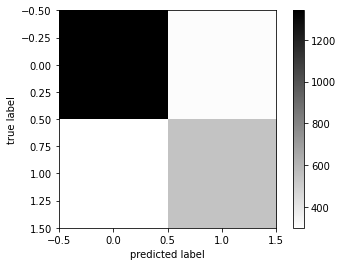

In [43]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(Xtrain, ytrain)
ypred = dtc.predict(Xtest)
print("Accuracy: %f\n" % metrics.accuracy_score(ypred, ytest))

confusion_matrix = metrics.confusion_matrix(ypred, ytest)
print("Confusion Matrix: ")
print(confusion_matrix)
print()

plt.imshow(confusion_matrix,
           interpolation='nearest', cmap=plt.cm.binary)
plt.grid(False)
plt.colorbar()
plt.xlabel("predicted label")
plt.ylabel("true label");


## Random Forest Classifier

The next classifier that we will look at is the [Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)


Accuracy: 0.838400

Confusion Matrix: 
[[1502  264]
 [ 140  594]]



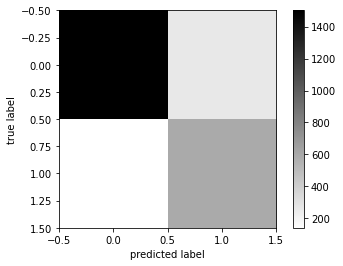

In [44]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100, random_state=0)
rfc.fit(Xtrain, ytrain)
ypred = rfc.predict(Xtest)
print("Accuracy: %f\n" % metrics.accuracy_score(ypred, ytest))

confusion_matrix = metrics.confusion_matrix(ypred, ytest)
print("Confusion Matrix: ")
print(confusion_matrix)
print()

plt.imshow(confusion_matrix,
           interpolation='nearest', cmap=plt.cm.binary)
plt.grid(False)
plt.colorbar()
plt.xlabel("predicted label")
plt.ylabel("true label");

## AdaBoost Classifier

How about an [AdaBoost Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier)


Accuracy: 0.822400

Confusion Matrix: 
[[1438  240]
 [ 204  618]]



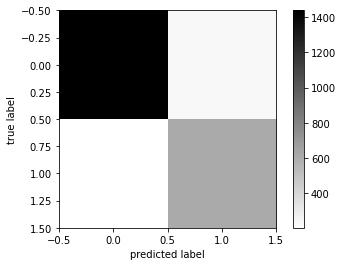

In [45]:
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier(random_state=0)
abc.fit(Xtrain, ytrain)
ypred = abc.predict(Xtest)
print("Accuracy: %f\n" % metrics.accuracy_score(ypred, ytest))

confusion_matrix = metrics.confusion_matrix(ypred, ytest)
print("Confusion Matrix: ")
print(confusion_matrix)
print()

plt.imshow(confusion_matrix,
           interpolation='nearest', cmap=plt.cm.binary)
plt.grid(False)
plt.colorbar()
plt.xlabel("predicted label")
plt.ylabel("true label");

## Gaussian Naive Bayes

Did someone say "[Gaussian Naive Bays](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB)"?

Accuracy: 0.681600

Confusion Matrix: 
[[1237  391]
 [ 405  467]]



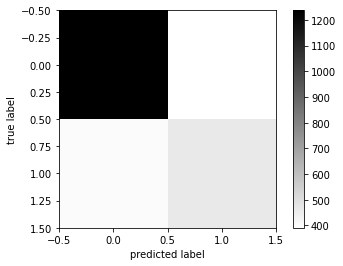

In [46]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(Xtrain, ytrain)
ypred = gnb.predict(Xtest)
print("Accuracy: %f\n" % metrics.accuracy_score(ypred, ytest))

confusion_matrix = metrics.confusion_matrix(ypred, ytest)
print("Confusion Matrix: ")
print(confusion_matrix)
print()

plt.imshow(confusion_matrix,
           interpolation='nearest', cmap=plt.cm.binary)
plt.grid(False)
plt.colorbar()
plt.xlabel("predicted label")
plt.ylabel("true label");

## QuadraticDiscriminantAnalysis

Everyone's favorite - [QuadraticDiscriminantAnalysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html#sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis)

Accuracy: 0.743200

Confusion Matrix: 
[[1387  387]
 [ 255  471]]



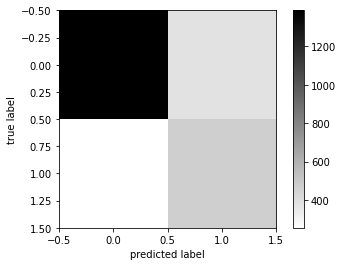

In [47]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda = QuadraticDiscriminantAnalysis()
qda.fit(Xtrain, ytrain)
ypred = qda.predict(Xtest)
print("Accuracy: %f\n" % metrics.accuracy_score(ypred, ytest))

confusion_matrix = metrics.confusion_matrix(ypred, ytest)
print("Confusion Matrix: ")
print(confusion_matrix)
print()

plt.imshow(confusion_matrix,
           interpolation='nearest', cmap=plt.cm.binary)
plt.grid(False)
plt.colorbar()
plt.xlabel("predicted label")
plt.ylabel("true label");

## K-Nearest Neighbors

Will you be my [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)?


Accuracy: 0.785200

Confusion Matrix: 
[[1399  294]
 [ 243  564]]



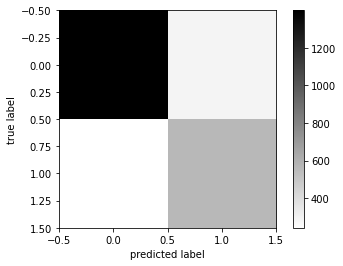

In [48]:
from sklearn.neighbors import KNeighborsClassifier
knc = KNeighborsClassifier()
knc.fit(Xtrain, ytrain)
ypred = knc.predict(Xtest)
print("Accuracy: %f\n" % metrics.accuracy_score(ypred, ytest))

confusion_matrix = metrics.confusion_matrix(ypred, ytest)
print("Confusion Matrix: ")
print(confusion_matrix)
print()

plt.imshow(confusion_matrix,
           interpolation='nearest', cmap=plt.cm.binary)
plt.grid(False)
plt.colorbar()
plt.xlabel("predicted label")
plt.ylabel("true label");

## Multi-Layer Perceptron Classifier

We can't have AI without [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier)



Accuracy: 0.688800

Confusion Matrix: 
[[1454  590]
 [ 188  268]]



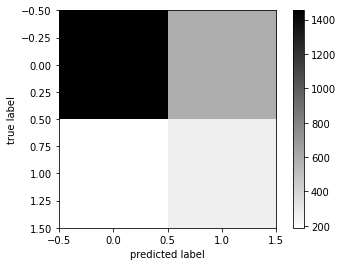

In [49]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
mlp.fit(Xtrain, ytrain)
ypred = mlp.predict(Xtest)
print("Accuracy: %f\n" % metrics.accuracy_score(ypred, ytest))

confusion_matrix = metrics.confusion_matrix(ypred, ytest)
print("Confusion Matrix: ")
print(confusion_matrix)
print()

plt.imshow(confusion_matrix,
           interpolation='nearest', cmap=plt.cm.binary)
plt.grid(False)
plt.colorbar()
plt.xlabel("predicted label")
plt.ylabel("true label");

## Dimensionality Reduction

Do we really need 166 attributes to be able to classify molecules as MUSK / NON-MUSK?

Are any of these attributes dependent on others?

We can use [Primary Component Analysis](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to give us a bit more information. First let's look at the explained variance ratio of the attributes (components) across the entire dataframe.

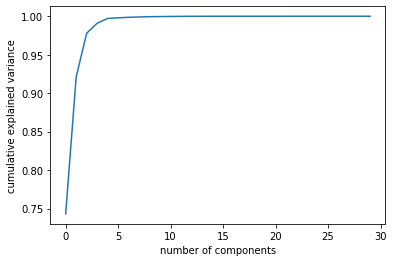

In [50]:
from sklearn.decomposition import PCA

pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

We can also use PCA to reduce the component count while keeping a percentage of the variance. The next step shows that 95% of the variance can be kept with only 35 components.

In [51]:
pca = PCA(0.95) # keep 95% of variance
Xtotal_xform = pca.fit_transform(X)
Xtrain_xform = pca.fit_transform(Xtrain)
Xtest_xform = pca.transform(Xtest)
print(X.shape)
print(Xtotal_xform.shape)
print("95% of the variance can be represented by "+ str((Xtrain_xform.shape[1] / X.shape[1] * 100)) + "% of the original components count!")

(10000, 30)
(10000, 3)
95% of the variance can be represented by 10.0% of the original components count!


## Classification with Dimensionality Reduction

Now let's try repeating the classification exercise with the reduced dimensionality dataframe.

Accuracy: 0.697600

Confusion Matrix: 
[[1266  380]
 [ 376  478]]



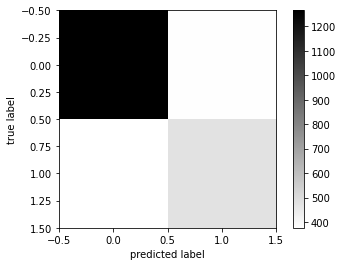

In [52]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(Xtrain_xform, ytrain)
ypred = dtc.predict(Xtest_xform)
print("Accuracy: %f\n" % metrics.accuracy_score(ypred, ytest))

confusion_matrix = metrics.confusion_matrix(ypred, ytest)
print("Confusion Matrix: ")
print(confusion_matrix)
print()

plt.imshow(confusion_matrix,
           interpolation='nearest', cmap=plt.cm.binary)
plt.grid(False)
plt.colorbar()
plt.xlabel("predicted label")
plt.ylabel("true label");


## K-Fold Validation

Initially, we have been splitting the data into a 75% training set and a 25% testing set by random sampling. This is commonly called "Cross-validation". 

From [Machine Learning Mastery](https://machinelearningmastery.com/k-fold-cross-validation/):
Cross-validation is primarily used in applied machine learning to estimate the skill of a machine learning model on unseen data. That is, to use a limited sample in order to estimate how the model is expected to perform in general when used to make predictions on data not used during the training of the model.

An additional approach is known as k-Fold Validation:
The procedure has a single parameter called k that refers to the number of groups that a given data sample is to be split into. As such, the procedure is often called k-fold cross-validation. When a specific value for k is chosen, it may be used in place of k in the reference to the model, such as k=10 becoming 10-fold cross-validation.

In [53]:
# 2-fold cross-validation
X1, X2, y1, y2 = train_test_split(X, y, test_size=0.5, random_state=0)
X1.shape, X2.shape

((5000, 30), (5000, 30))

In [54]:
print(SVC(kernel='rbf', gamma='scale').fit(X2, y2).score(X1, y1))
print(SVC(kernel='rbf', gamma='scale').fit(X1, y1).score(X2, y2))

0.688
0.696


In [55]:
from sklearn.model_selection import cross_val_score
cv = cross_val_score(SVC(kernel='rbf', gamma='scale'), X, y, cv=2)
cv.mean()

0.6918

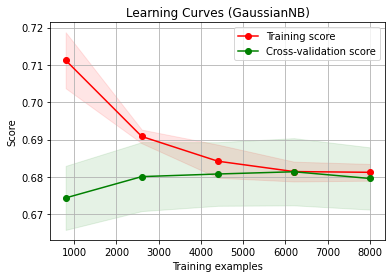

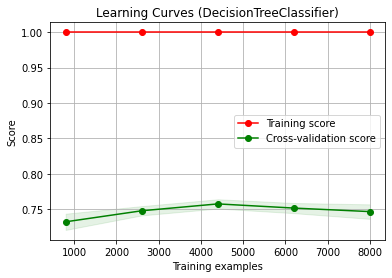

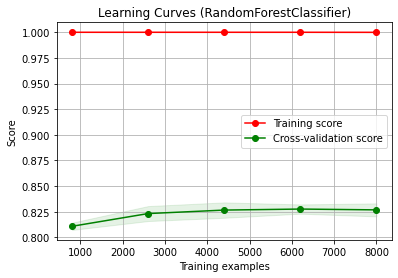

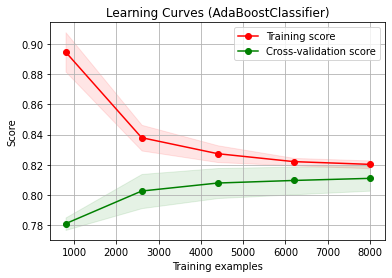

In [56]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=5)

    # train_scores = result[0]
    # valid_scores = result[1]
    title = "Learning Curves ("+ type(estimator).__name__ + ")"
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

plot_learning_curve(GaussianNB())
# plot_learning_curve(SVC())
plot_learning_curve(DecisionTreeClassifier())
plot_learning_curve(RandomForestClassifier(n_estimators=100))
plot_learning_curve(AdaBoostClassifier())
# plot_learning_curve(QuadraticDiscriminantAnalysis())
# plot_learning_curve(KNeighborsClassifier())